In [ ]:
from FundSelection import FundSelection
from Portfolio import Portfolio
from functools import reduce
import pandas as pd

PORTFOLIO_YEARS = 6
N_PORTFOLIOS = 1000000
RISK_FREE_RATE = 0.0375 


# Benchmark
benchmark = [
    FundSelection('Ranmore Global Equity Investor GBP', 0.25),
    FundSelection('L&G Global 100 Index I Acc', 0.13, proxy_funds=[FundSelection('Fidelity Global Technology W-Acc-GBP', 1.0)]),
    FundSelection('MFS Meridian Contrarian Value W1 GBP', 0.06),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP', 0.06),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc', 0.10),
    FundSelection('BH Macro GBP Ord', 0.10),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.10),
    FundSelection('Winton Trend UCITS I GBP Acc', 0.05),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP',0.05),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.05),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc', 0.05)
]

# Equity
equity_fund_selection = [
    #FundSelection('Artemis Global Income I Acc'),
    #FundSelection('Artemis SmartGARP Glb EM Eq I Acc GBP'),
    FundSelection('Ranmore Global Equity Investor GBP'), # ~0.59 Correlated with global tracker
    #FundSelection('MFS Meridian Contrarian Value W1 GBP'), # ~0.74 Correlated with global tracker
    FundSelection('Orbis OEIC Global Balanced Standard'), # ~0.73 Correlated with global tracker
    #FundSelection('FAST - Global Fund Y-PF-ACC-GBP'), # ~0.49 Correlated with global tracker
    #FundSelection('WisdomTree Glb Efficient Cor ETFUSDAcc GBP', proxy_funds=[FundSelection('SPDR MSCI All Cntry Wld ETF GBP', 0.9), FundSelection('Vanguard Glb Bd Idx £ H Acc', 0.6)]),
    FundSelection('L&G Global 100 Index I Acc', proxy_funds=[FundSelection('Fidelity Global Technology W-Acc-GBP', 1.0)]),
    FundSelection('Winton Trend Enh Glbl Eq UCITSIGBPUnHAcc', proxy_funds=[FundSelection('Fidelity Global Technology W-Acc-GBP', 1.0)]),
    FundSelection('Ashoka India Equity Investment Ord'),
    FundSelection('Invesco S&P 500 QVM ETF GBP')
]

equity_portfolio = Portfolio(equity_fund_selection, benchmark, PORTFOLIO_YEARS)
equity_max_sharpe_portf = equity_portfolio.optimize_weights(N_PORTFOLIOS, RISK_FREE_RATE)

# Low Vol
low_vol_abridged_fund_selection = [
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc'),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc'),
    FundSelection('JPM Europe Equity Absolute Alpha C (perf) (dist) - GBP (hedged)'),
    #FundSelection('Man High Yield Opports Profl Acc C'), 
]

# Only data from 2022, so proxy earlier years with the best Sharpe ratio weghtings from the other funds
man_dynamic_income = FundSelection('Man Dynamic Income I H GBP Cap', proxy_funds=low_vol_abridged_fund_selection)

low_vol_full_fund_selection = low_vol_abridged_fund_selection + [
    man_dynamic_income
]

benchmark = [
    FundSelection('Ranmore Global Equity Investor GBP', 0.25),
    FundSelection('L&G Global 100 Index I Acc', 0.13, proxy_funds=[FundSelection('Fidelity Global Technology W-Acc-GBP', 1.0)]),
    FundSelection('MFS Meridian Contrarian Value W1 GBP', 0.06),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP', 0.06),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc', 0.10),
    FundSelection('BH Macro GBP Ord', 0.10),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.10),
    FundSelection('Winton Trend UCITS I GBP Acc', 0.05),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP',0.05),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.05),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc', 0.05)
]

# Abridged Portfolio excludes Man Dynamic - calculate max Sharpe Ratio and associated weights to backfill proxy fund weights in full portfolio
low_vol_abridged_portfolio = Portfolio(low_vol_abridged_fund_selection, benchmark, PORTFOLIO_YEARS)
low_vol_abridged_portfolio.optimize_weights(N_PORTFOLIOS, RISK_FREE_RATE)

# Full Portfolio - 1st 3 years of Man Dynamic Income fund backfilled with the proxy fund weights from the abridged portfolio
low_vol_portfolio = Portfolio(low_vol_full_fund_selection, benchmark, PORTFOLIO_YEARS)
low_vol_max_sharpe_portf = low_vol_portfolio.optimize_weights(N_PORTFOLIOS, RISK_FREE_RATE)

# Low Correlation
# iShares Physical Gold ETC GBP => WisdomTree Physical Gold GBP Daily Hdgd at some point to currency hedge
low_correlaton_fund_selection = [
    FundSelection('iShares Physical Gold ETC GBP'),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP'),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc'),
]

low_correlaton_portfolio = Portfolio(low_correlaton_fund_selection, benchmark, PORTFOLIO_YEARS)
low_correlaton_max_sharpe_portf = low_correlaton_portfolio.optimize_weights(N_PORTFOLIOS, RISK_FREE_RATE)

C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.136%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
c:\Users\Pandelus\source\repos\Portfolio\Jupyter\Portfolio.py:342: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=max_sharpe_portf['AverageReturns'][asset_index],
C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.105%' has dtype incompatible with float6

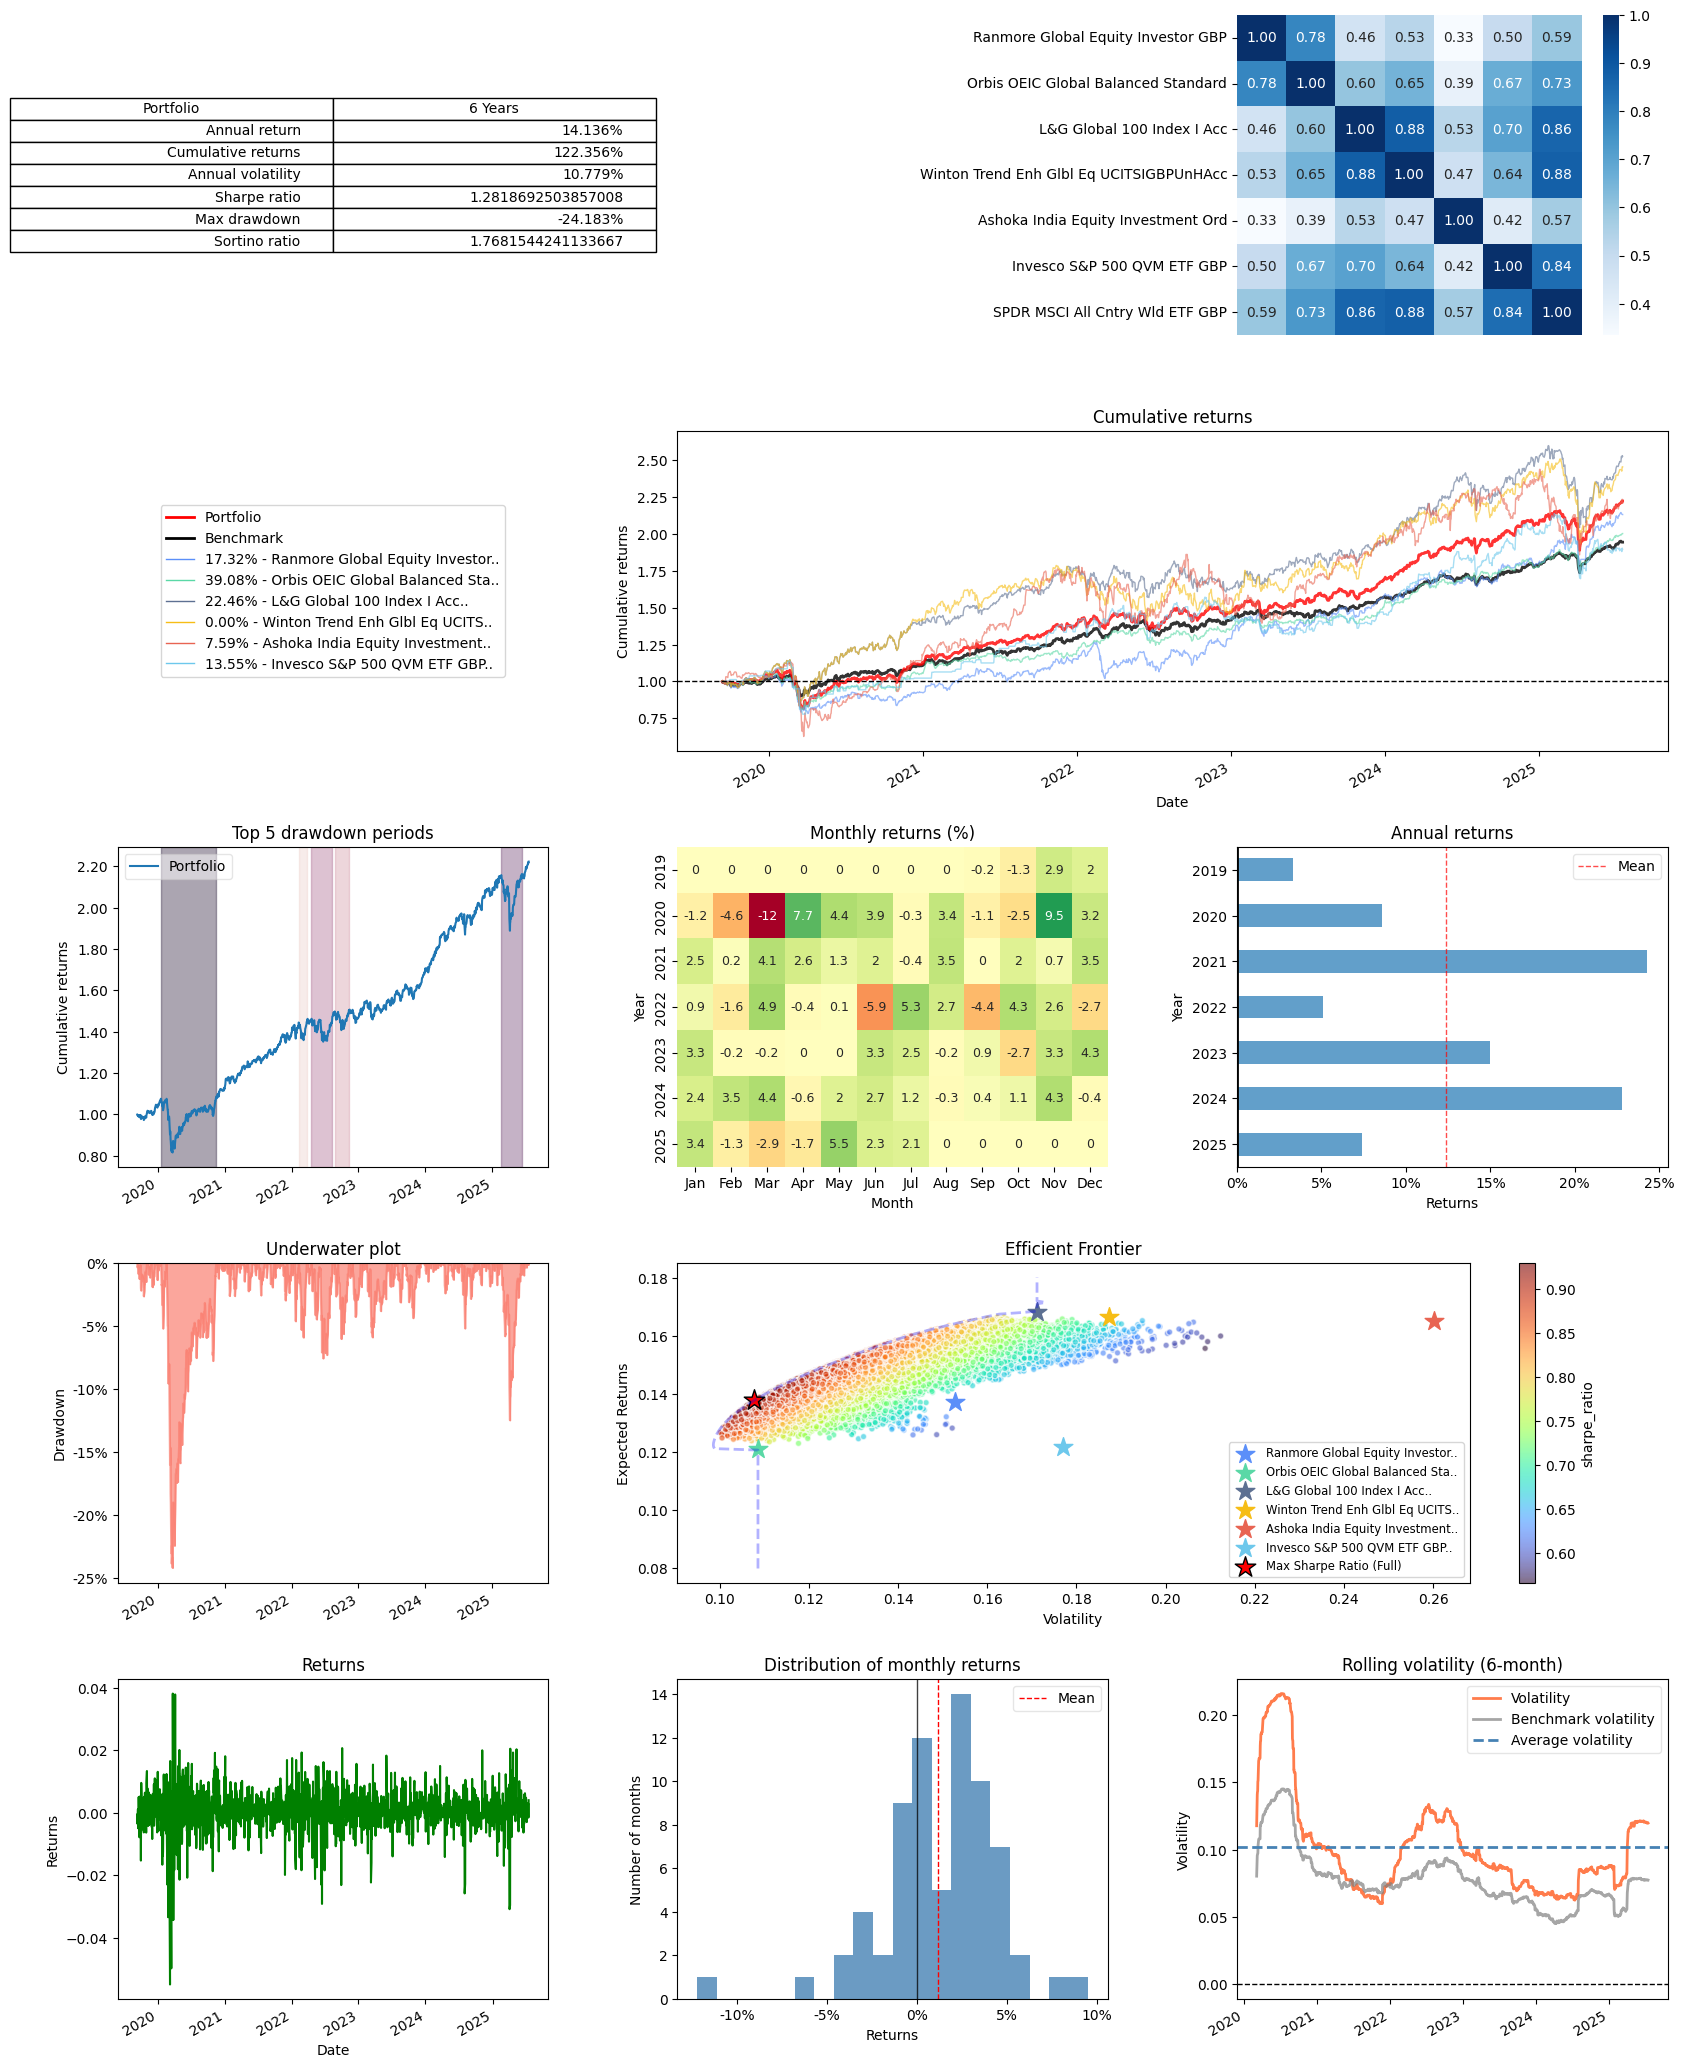

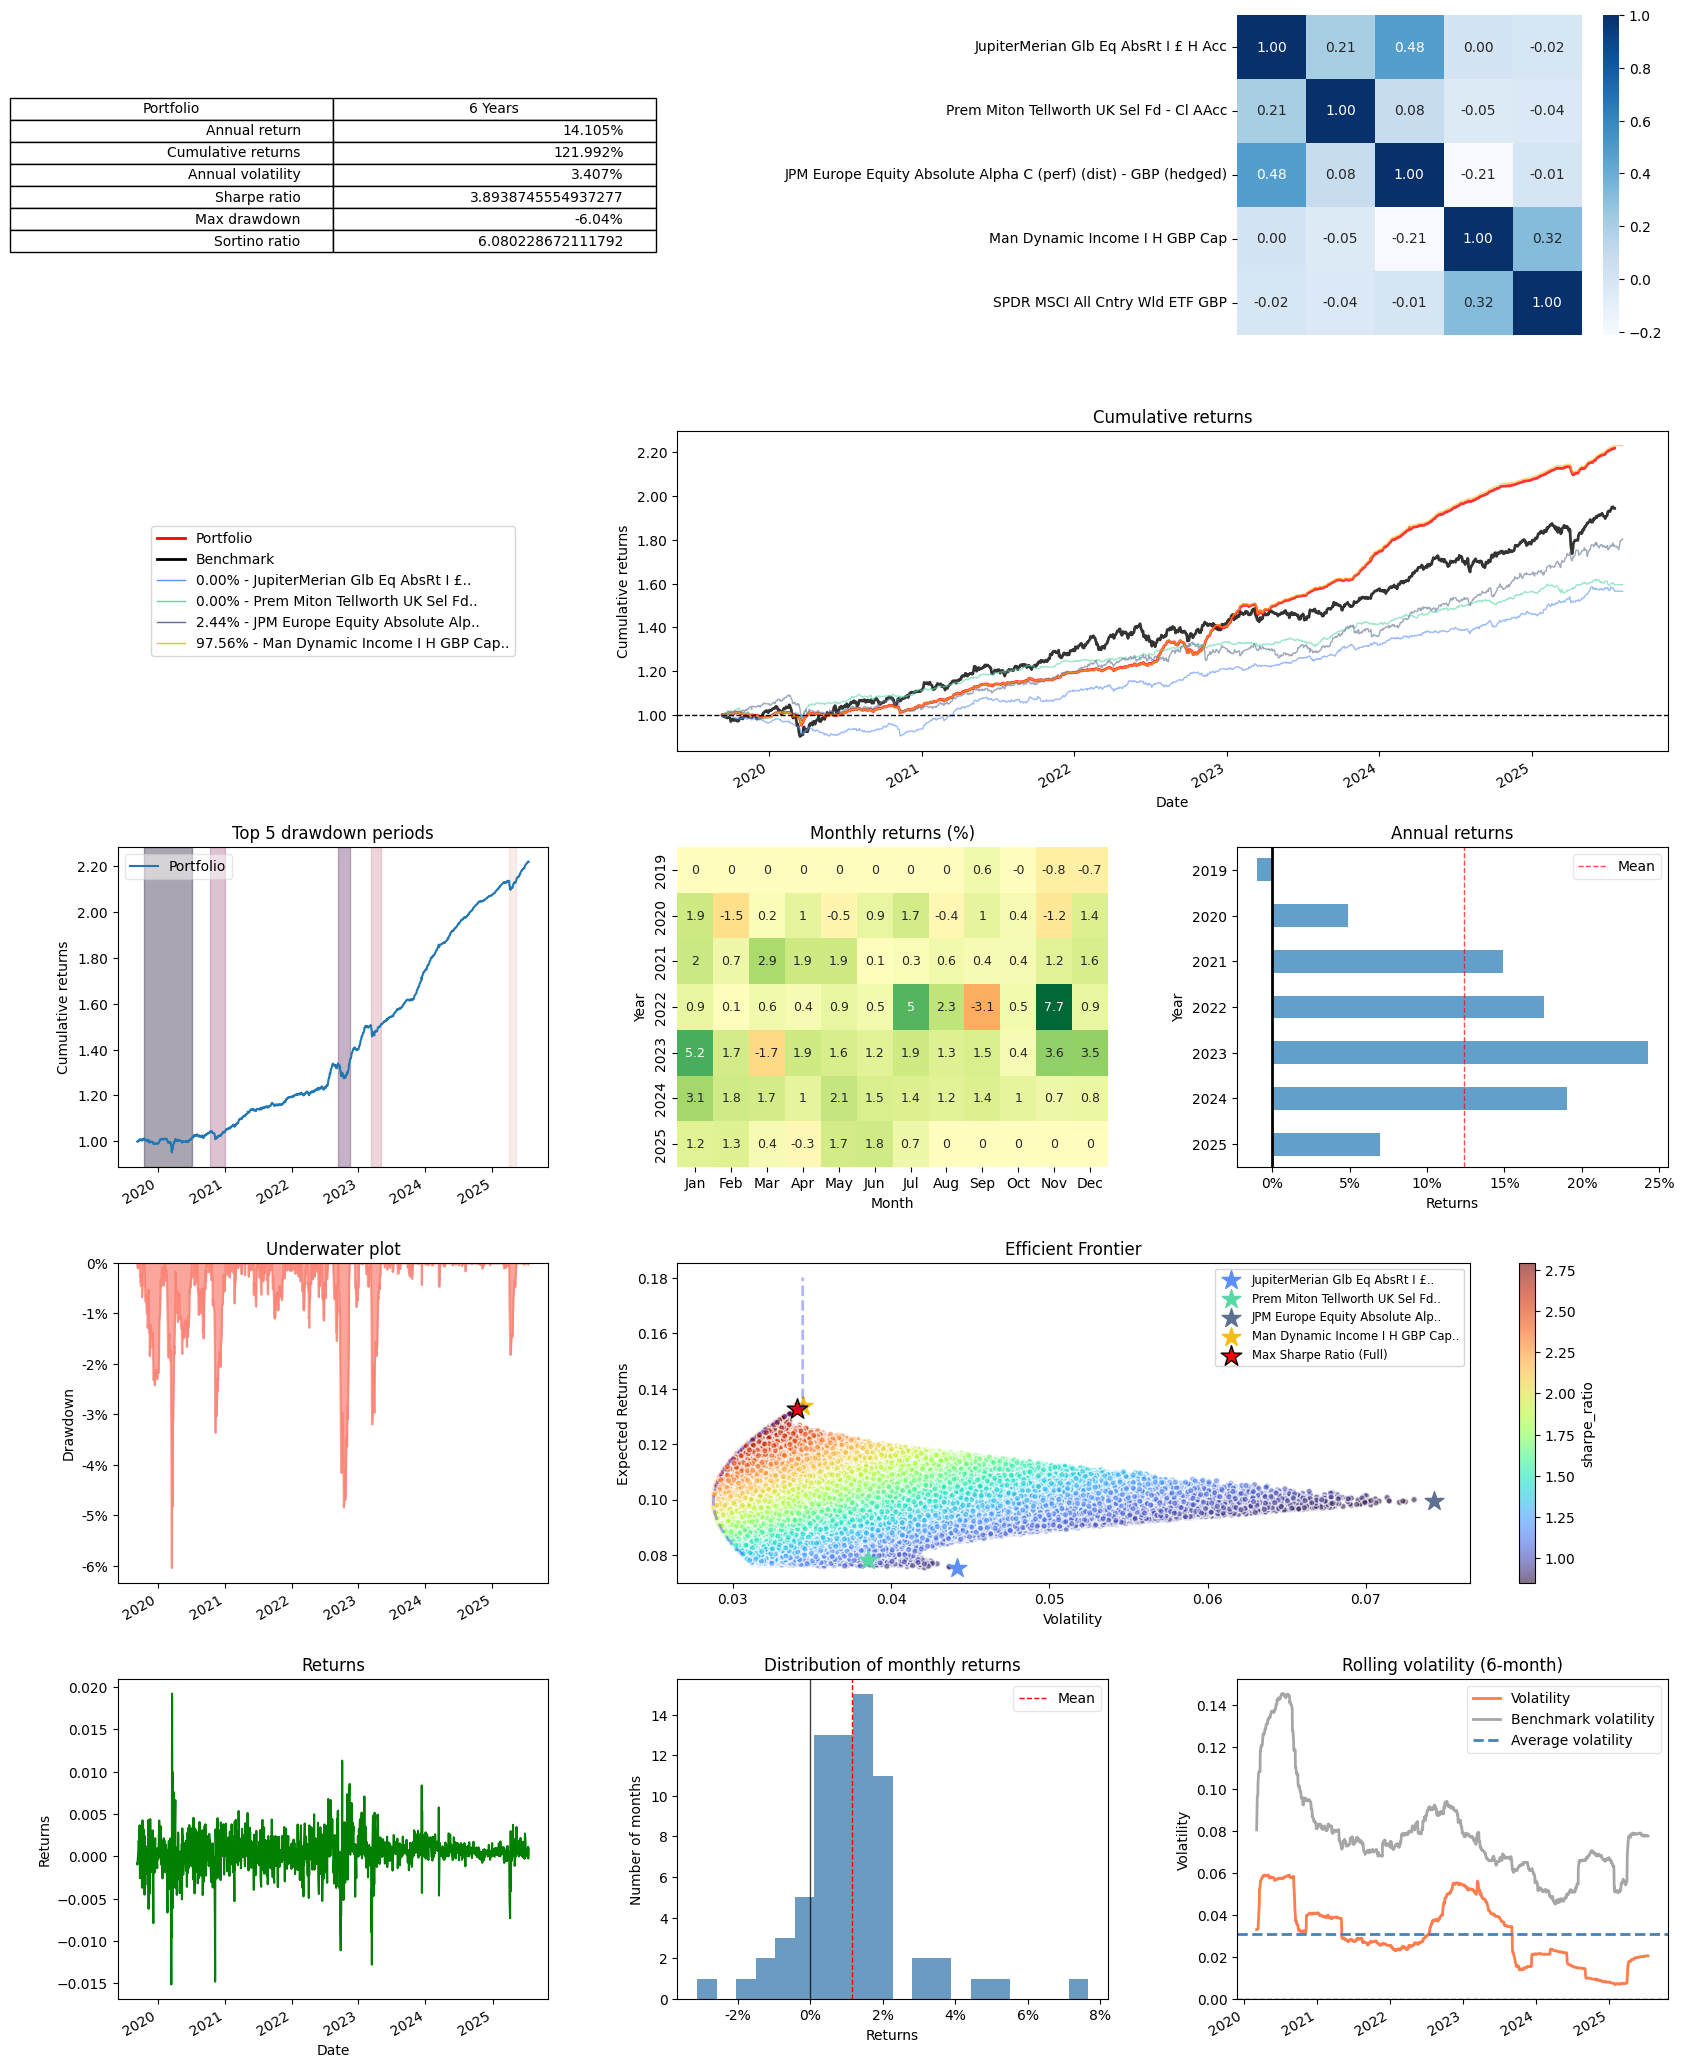

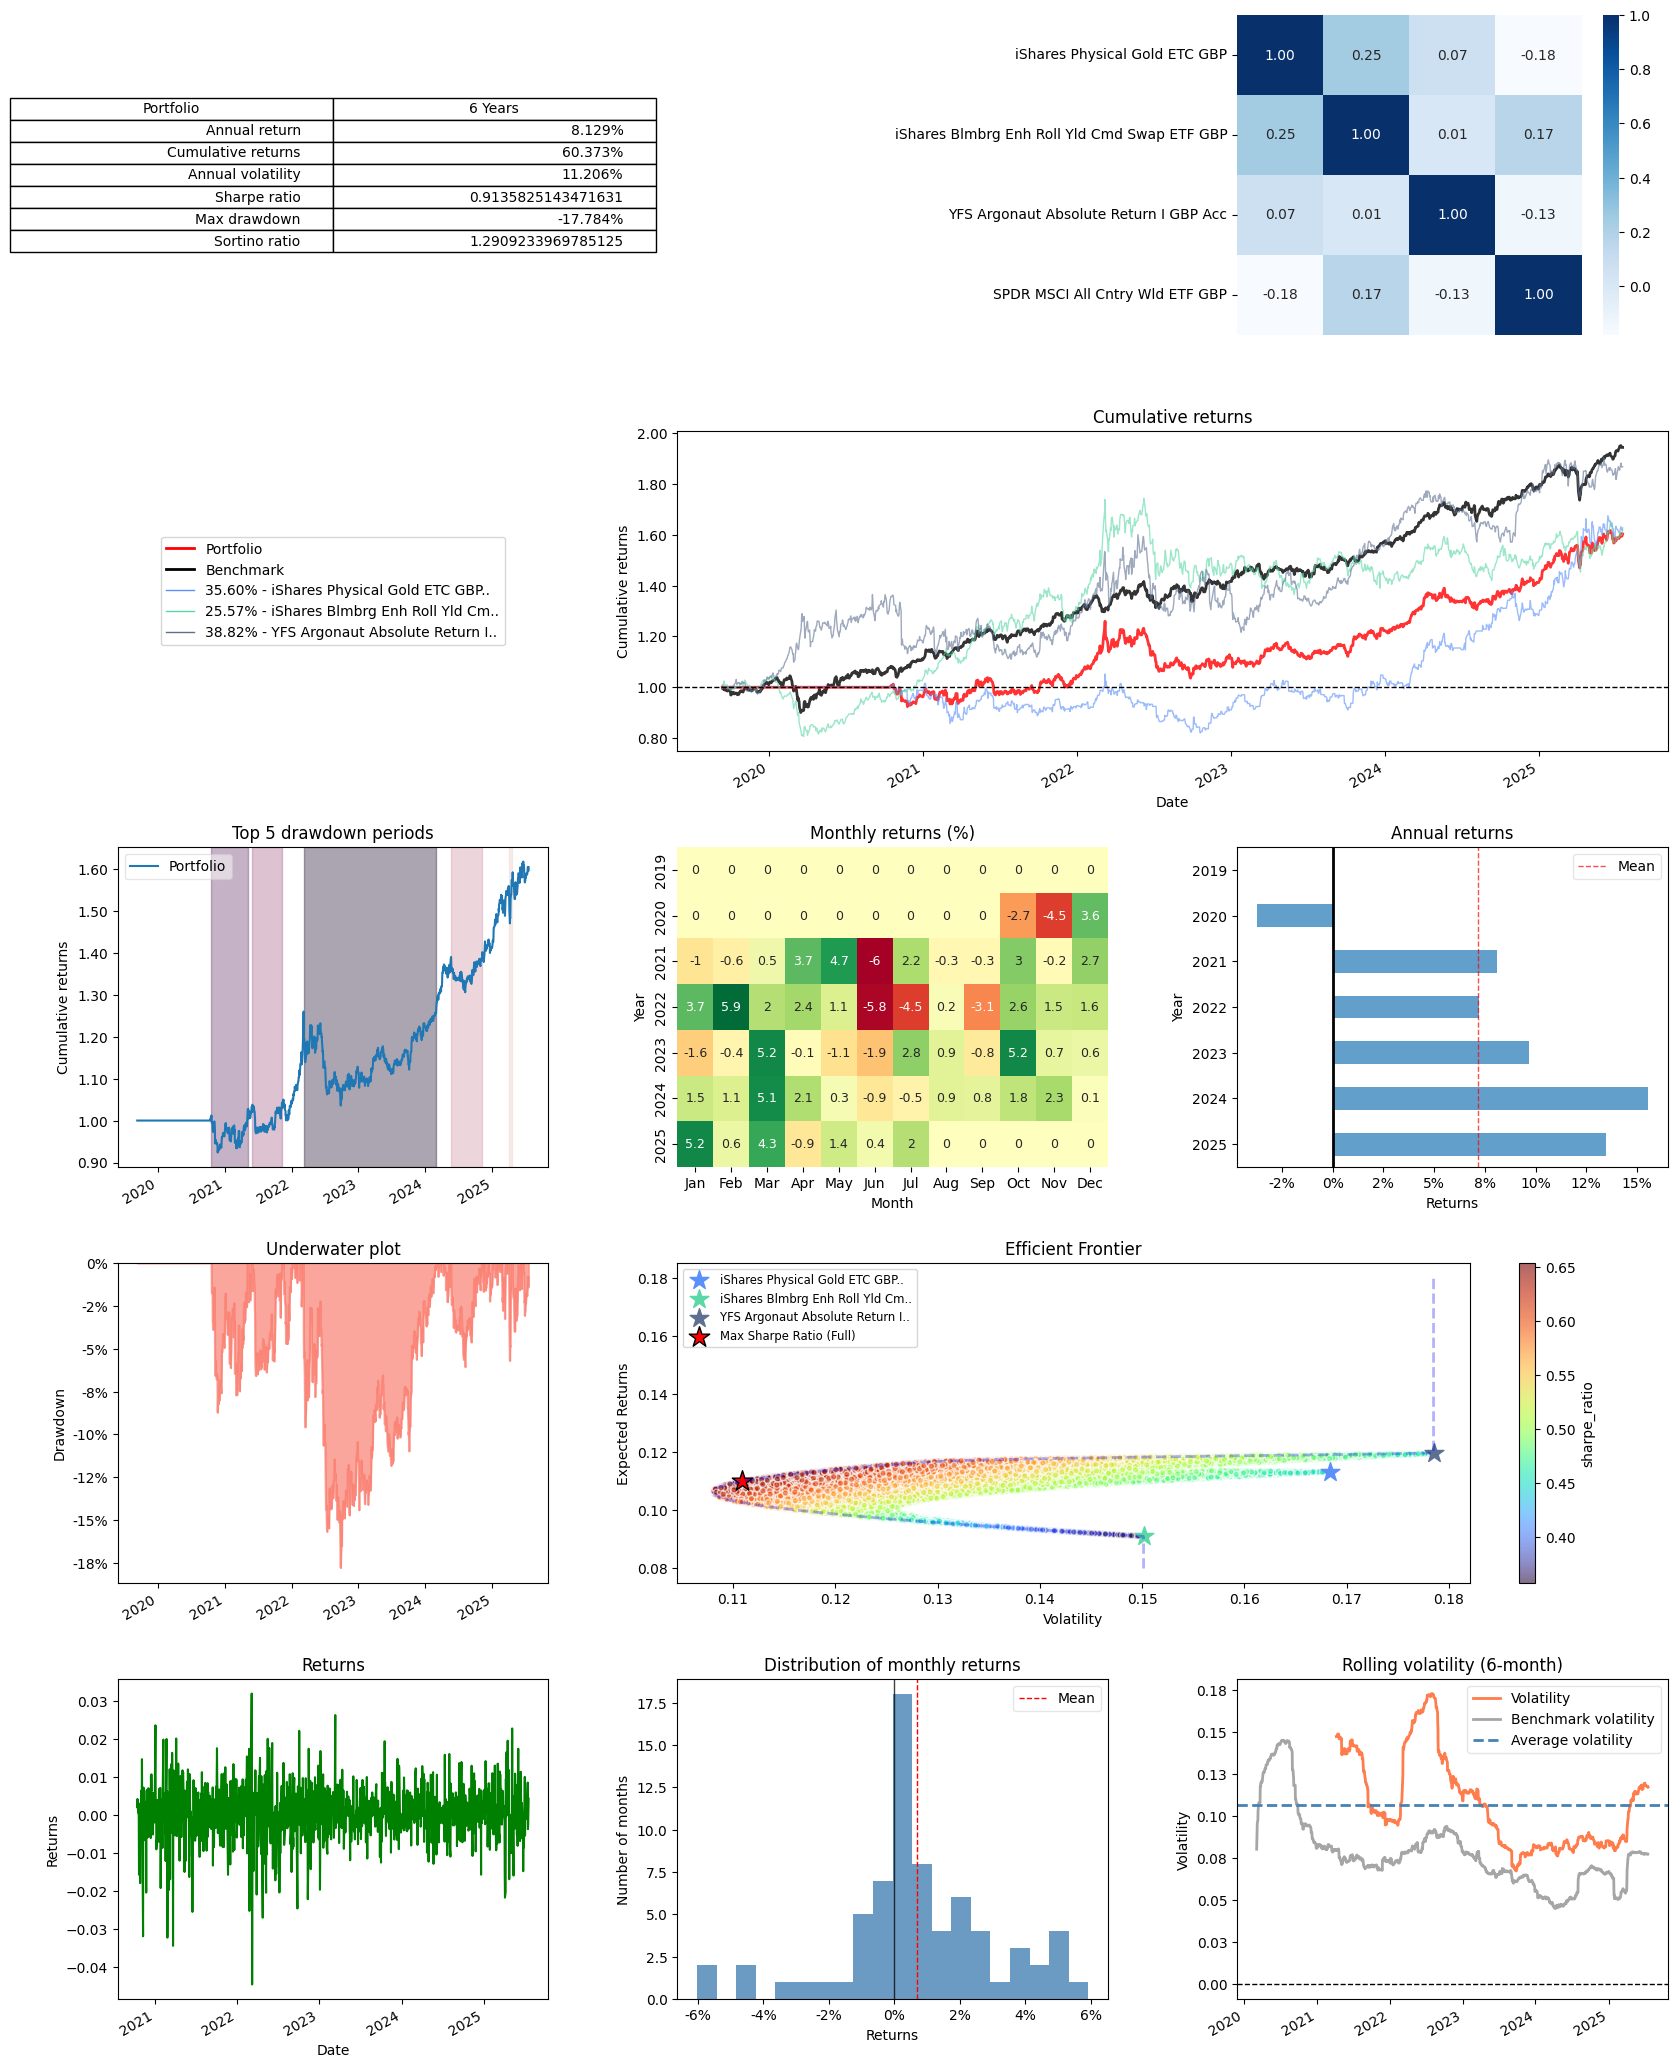

In [2]:
equity_portfolio.plot_returns_tear_sheet(equity_max_sharpe_portf)
low_vol_portfolio.plot_returns_tear_sheet(low_vol_max_sharpe_portf)
low_correlaton_portfolio.plot_returns_tear_sheet(low_correlaton_max_sharpe_portf)

In [4]:
equity_results = equity_portfolio.export('Equity')
low_vol_results = low_vol_portfolio.export('LowVol')
low_correlation_results = low_correlaton_portfolio.export('LowCorr')

combined_results = pd.concat([equity_results, low_vol_results, low_correlation_results])

# xlswriter needs to be installed
combined_results.to_excel('Portfolio.xlsx', index=True)



c:\Users\Pandelus\source\repos\Portfolio\Jupyter\Portfolio.py:713: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17322254591078098' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[name, 'Weight'] = name_weight[name]
c:\Users\Pandelus\source\repos\Portfolio\Jupyter\Portfolio.py:713: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9755915433128232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[name, 'Weight'] = name_weight[name]
c:\Users\Pandelus\source\repos\Portfolio\Jupyter\Portfolio.py:713: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3882461010754516' has dtype incompatible with int64, please explicitly cast to a compatible